In [1]:
from mlcolvar.data import DictDataset, DictModule
from mlcolvar.cvs import AutoEncoderCV
from mlcolvar.core.transform import Statistics
from mlcolvar.core.transform import Transform

import numpy as np
import mdtraj as md
import nglview as nv
import torch
import lightning
import pickle
from torch.optim import Adam
np.bool = np.bool_

from tqdm import tqdm
from pytorch_lightning import Trainer

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [12]:
molecule = "2JOF"
MLCV_DIM = 2

pdb_path = f"../data/{molecule}/{molecule}_from_mae.pdb"
traj = md.load_pdb(pdb_path)
print(traj)
view = nv.show_mdtraj(traj)
view.add_representation("licorice", selection="protein")
view

<mdtraj.Trajectory with 1 frames, 272 atoms, 20 residues, without unitcells>


NGLWidget()

## Dataset

In [13]:
timelag = 10
current_cad_path = f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-5k/current-cad.pt"
timelagged_cad_path = f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-5k/lag{timelag}-cad.pt"

current_cad = torch.load(current_cad_path)
timelagged_cad = torch.load(timelagged_cad_path)

print(current_cad.shape)
print(timelagged_cad.shape)

torch.Size([5000, 190])
torch.Size([5000, 190])


In [14]:
new_dataset = DictDataset({
	"data": current_cad,
	"target": timelagged_cad
})
datamodule = DictModule(new_dataset,lengths=[0.8,0.2])

## Train

In [15]:
class TAE(AutoEncoderCV):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def backward(self, loss):
        loss.backward(retain_graph=True)
    

In [16]:
options = {
	"encoder": {
		"activation": "tanh",
		"dropout": [0.5, 0.5, 0.5],
	}
}
model = TAE(
    encoder_layers=[current_cad.shape[1], 100, 100, MLCV_DIM],
    options=options
)
model

TAE(
  (loss_fn): MSELoss()
  (norm_in): Normalization(in_features=190, out_features=190, mode=mean_std)
  (encoder): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=190, out_features=100, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=100, out_features=100, bias=True)
      (4): Tanh()
      (5): Dropout(p=0.5, inplace=False)
      (6): Linear(in_features=100, out_features=2, bias=True)
      (7): Dropout(p=0.5, inplace=False)
    )
  )
  (decoder): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=2, out_features=100, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=100, out_features=100, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=100, out_features=190, bias=True)
    )
  )
)

In [17]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from mlcolvar.utils.trainer import MetricsCallback

# define callbacks
metrics = MetricsCallback()
early_stopping = EarlyStopping(monitor="valid_loss", min_delta=0.1, patience=50)

# define trainer
trainer = lightning.Trainer(
    callbacks=[metrics, early_stopping],
	max_epochs=None,
 	logger=None,
  	enable_checkpointing=False
)

# fit
trainer.fit( model, datamodule )
model.eval()

Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/shpark/.conda/envs/bioemu/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/home/shpark/.conda/envs/bioemu/lib/python3.10/site-package

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/shpark/.conda/envs/bioemu/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

TAE(
  (loss_fn): MSELoss()
  (norm_in): Normalization(in_features=190, out_features=190, mode=mean_std)
  (encoder): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=190, out_features=100, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=100, out_features=100, bias=True)
      (4): Tanh()
      (5): Dropout(p=0.5, inplace=False)
      (6): Linear(in_features=100, out_features=2, bias=True)
      (7): Dropout(p=0.5, inplace=False)
    )
  )
  (decoder): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=2, out_features=100, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=100, out_features=100, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=100, out_features=190, bias=True)
    )
  )
)

## Evaluation

### Normalization

In [18]:
def sanitize_range(range: torch.Tensor):
    """Sanitize

    Parameters
    ----------
    range : torch.Tensor
        range to be used for standardization

    """

    if (range < 1e-6).nonzero().sum() > 0:
        print(
            "[Warning] Normalization: the following features have a range of values < 1e-6:",
            (range < 1e-6).nonzero(),
        )
    range[range < 1e-6] = 1.0

    return range

class PostProcess(Transform):
    def __init__(
        self,
        stats = None,
        reference_frame_cv = None,
        feature_dim = 1,
    ):
        super().__init__(in_features=feature_dim, out_features=feature_dim)
        self.register_buffer("mean", torch.zeros(feature_dim))
        self.register_buffer("range", torch.ones(feature_dim))
        
        if stats is not None:
            min = stats["min"]
            max = stats["max"]
            self.mean = (max + min) / 2.0
            range = (max - min) / 2.0
            self.range = sanitize_range(range)
        
        if reference_frame_cv is not None:
            self.register_buffer(
                "flip_sign",
                torch.ones(1) * -1 if reference_frame_cv < 0 else torch.ones(1)
            )
        else:
            self.register_buffer("flip_sign", torch.ones(1))
        
    def forward(self, x):
        x = x.sub(self.mean).div(self.range)
        x = x * self.flip_sign
        
        return x


In [19]:
projection_data_path = f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-all/cad.pt"
projection_data = torch.load(projection_data_path)

model.eval()
cv = model(projection_data)
cv = cv.detach().numpy()
print(cv.shape)

(530000, 2)


In [20]:
stats = Statistics(torch.from_numpy(cv).cpu()).to_dict()
model.postprocessing = PostProcess(stats).to(model.device)
postprocessed_cv = model(projection_data)
print(cv.max())
print(cv.min())
print(postprocessed_cv.max())
print(postprocessed_cv.min())

3.347545
-3.759996
tensor(1., grad_fn=<MaxBackward1>)
tensor(-1., grad_fn=<MinBackward1>)


In [26]:
model_save_dir = "/home/shpark/prj-mlcv/lib/bioemu/model"
model_name = "tae"
torch.save(model.state_dict(), f"{model_save_dir}/_baseline_/{model_name}-{molecule}.pt")

model.trainer = Trainer(logger=False, enable_checkpointing=False, enable_model_summary=False)
input_dim = datamodule.dataset["data"].shape[1]
random_input = torch.rand(1, input_dim).to(model.device)
traced_script_module = torch.jit.trace(model, random_input)
traced_script_module.save(f"{model_save_dir}/_baseline_/{model_name}-{molecule}-jit.pt")

Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


### TICA

In [23]:
with open(f'../data/{molecule}/{molecule}_tica_model_lag{timelag}.pkl', 'rb') as f:
    tica = pickle.load(f)
print(tica)

TICA(commute_map=False, dim=2, epsilon=1e-06, kinetic_map=True, lag=10,
   ncov_max=inf, reversible=True, skip=0, stride=1, var_cutoff=0.95,
   weights=None)


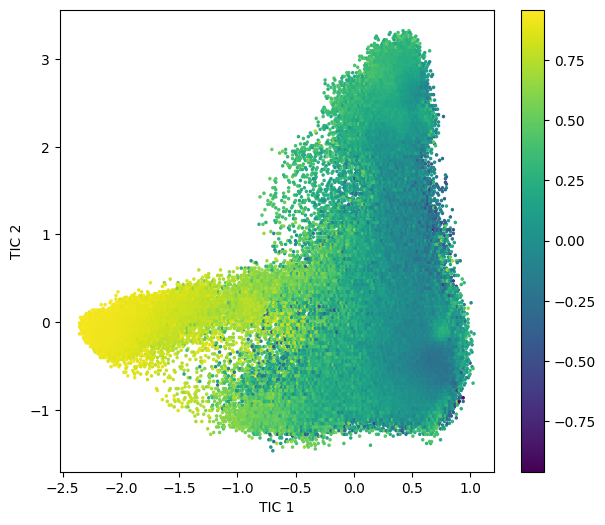

In [25]:
# projection_data_np_switch = (1 - np.power(projection_data_np / 0.8, 6)) / (1 - np.power(projection_data_np / 0.8, 12))
# tica_coord = tica.transform(projection_data_np_switch)

projection_data_np = projection_data.numpy()
tica_coord = tica.transform(projection_data_np)
postprocessed_cv_numpy = postprocessed_cv.detach().cpu().numpy()

# Plot
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)
hb = ax.hexbin(
	tica_coord[:, 0], tica_coord[:, 1], C=-postprocessed_cv_numpy[:, 0],  # data
	gridsize=200,                     # controls resolution
	reduce_C_function=np.mean,       # compute average per hexagon
	cmap='viridis',                  # colormap
)
plt.colorbar(hb)
# plt.scatter(tica_state[:, 0], tica_state[:, 1], c='red', s=10)
plt.xlabel("TIC 1")
plt.ylabel("TIC 2")
plt.show()